In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
#print(os.listdir("../input"))

import time

import matplotlib.pyplot as plt
import seaborn as sns
import gc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

path='/Users/alessandrorivello/Kaggle/dados_kaggle/'

In [37]:
# Setting the data types before importing (instead of letting pandas guess it) can improve 
# performance and use less RAM
# Reference: https://www.kaggle.com/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'days'          : 'uint8',
        'hours'         : 'uint8',
        'minutes'       : 'uint8',
        'seconds'       : 'uint8',
        }

In [38]:
# We delete the attributed_time column since it has a lot of missing values and might not be so informative
# Reference: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/51411
cols = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'days', 'hours', 'minutes','seconds']

In [39]:
# Note that we're using 10_train_timed and not the original file. This file represents 10% of the full train data
# and the column click_time was split into its components days, hours, minutes and seconds. Besides that, we also
# deleted the year and month component saving us a lot of memory space

train=pd.read_csv(path + '10_train_timed.csv', dtype=dtypes, usecols = cols)

In [40]:
dtypes2 = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'days'          : 'uint8',
        'hours'         : 'uint8',
        'minutes'       : 'uint8',
        'seconds'       : 'uint8',
        }

test=pd.read_csv(path + 'test_timed.csv', index_col=0, dtype=dtypes2)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [41]:
test.head()

,ip,app,device,os,channel,days,hours,minutes,seconds
click_id,,,,,,,,,
0,5744,9,1,3,107,10,4,0,0
1,119901,9,1,3,466,10,4,0,0
2,72287,21,1,19,128,10,4,0,0
3,78477,15,1,13,111,10,4,0,0
4,123080,12,1,13,328,10,4,0,0


In [42]:
train.head()

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds
0,103022,3,1,23,379,0,6,14,37,44
1,114221,3,1,19,379,0,6,14,37,59
2,47902,3,1,17,379,0,6,14,48,7
3,23550,3,1,13,379,0,6,14,53,39
4,84644,3,1,19,379,0,6,14,56,49


In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18490388 entries, 0 to 18490387
Data columns (total 10 columns):
ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed    uint8
days             uint8
hours            uint8
minutes          uint8
seconds          uint8
dtypes: uint16(4), uint32(1), uint8(5)
memory usage: 299.8 MB


In [44]:

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18790469 entries, 0 to 18790468
Data columns (total 9 columns):
ip         uint32
app        uint16
device     uint16
os         uint16
channel    uint16
days       uint8
hours      uint8
minutes    uint8
seconds    uint8
dtypes: uint16(4), uint32(1), uint8(4)
memory usage: 430.1 MB


/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


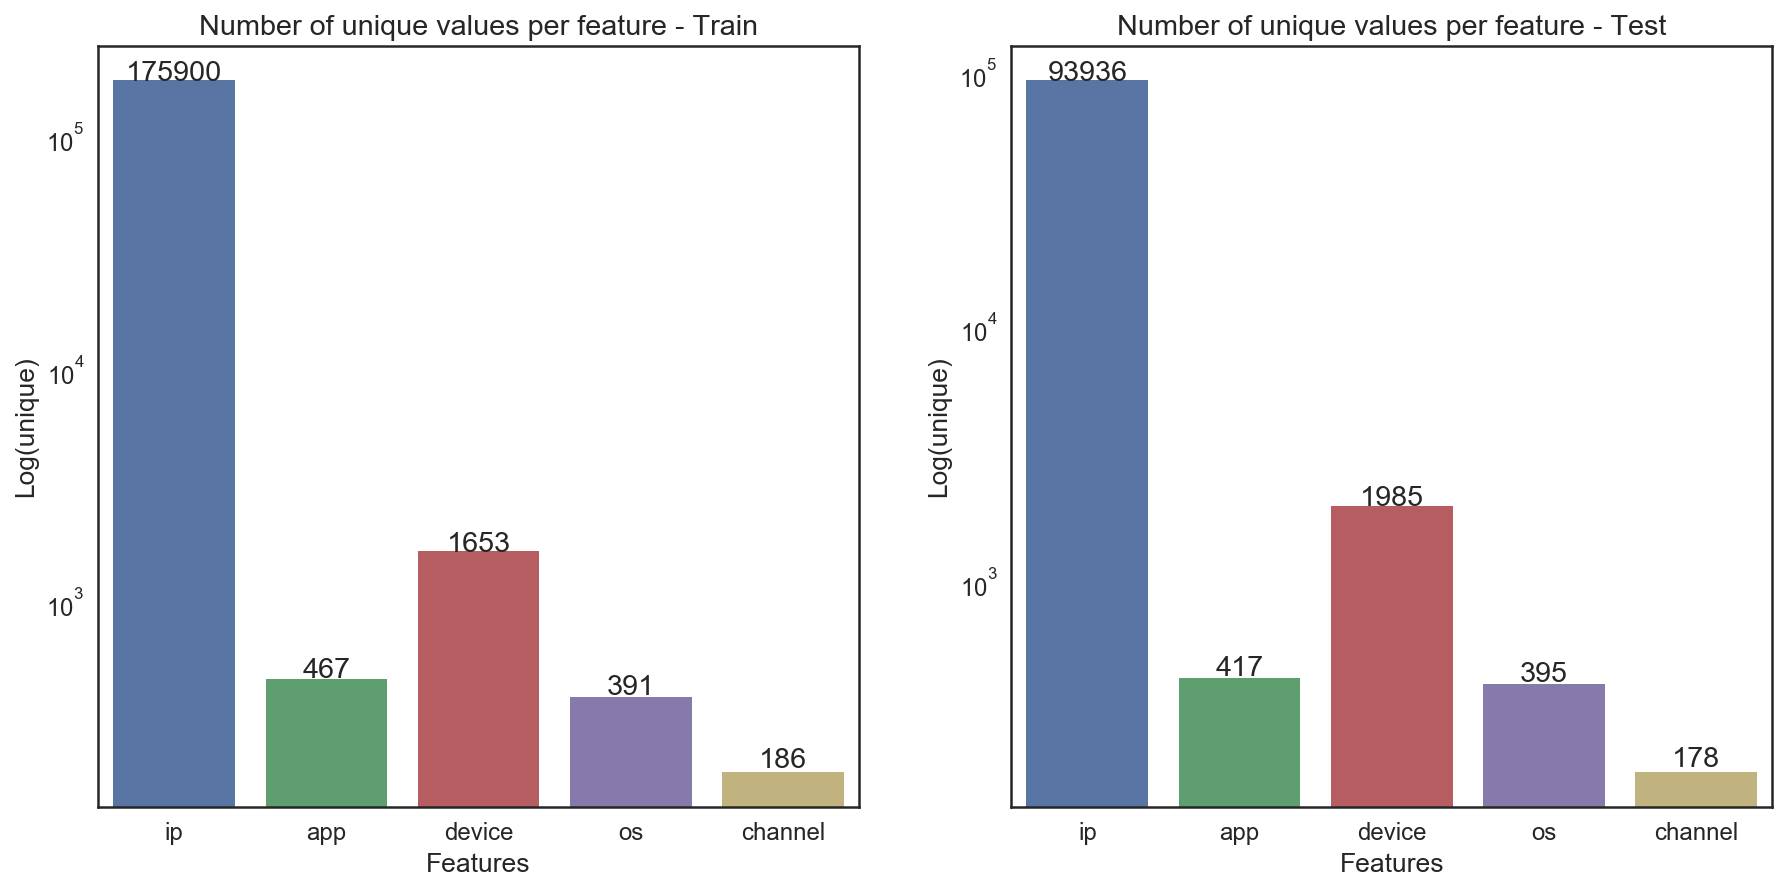

In [45]:
plt.figure(figsize=(10,6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques_train = [len(train[col].unique()) for col in cols]
uniques_test = [len(test[col].unique()) for col in cols]

sns.set(font_scale=1.2)
sns.set_style('white')

fig, axs = plt.subplots(1, 2,figsize=(15,7))
graph_train = sns.barplot(cols, uniques_train, ax=axs[0], log=True)
graph_test = sns.barplot(cols, uniques_test, ax=axs[1], log=True)

graph_train.set(xlabel='Features', ylabel='Log(unique)', title='Number of unique values per feature - Train')
graph_test.set(xlabel='Features', ylabel='Log(unique)', title='Number of unique values per feature - Test')

for t, tt, uniq_t, uniq_tt in zip(graph_train.patches, graph_test.patches, uniques_train, uniques_test):
    height_train=t.get_height()
    height_test=tt.get_height()
    graph_train.text(t.get_x()+t.get_width()/2.,
            height_train + 10,
            uniq_t,
            ha="center") 
    graph_test.text(tt.get_x()+tt.get_width()/2.,
            height_test + 10,
            uniq_tt,
            ha="center") 


Como esperado o número de registros únicos é muito maior entre IPs do que entre os outros dados. Achamos esse resultado natural uma vez que um aplicativo muito popular pode ser baixado milhares de vezes; é fácil conceber que existão milhares de hardware com o mesmo OS e assim por diante.
Como o objetivo final será identificar os cliques falsos (aqueles que clicam, mas não fazem dowload), vamos ver como se comprta a taxa de conversão (número de downloads vs número total de cliques) nos dados

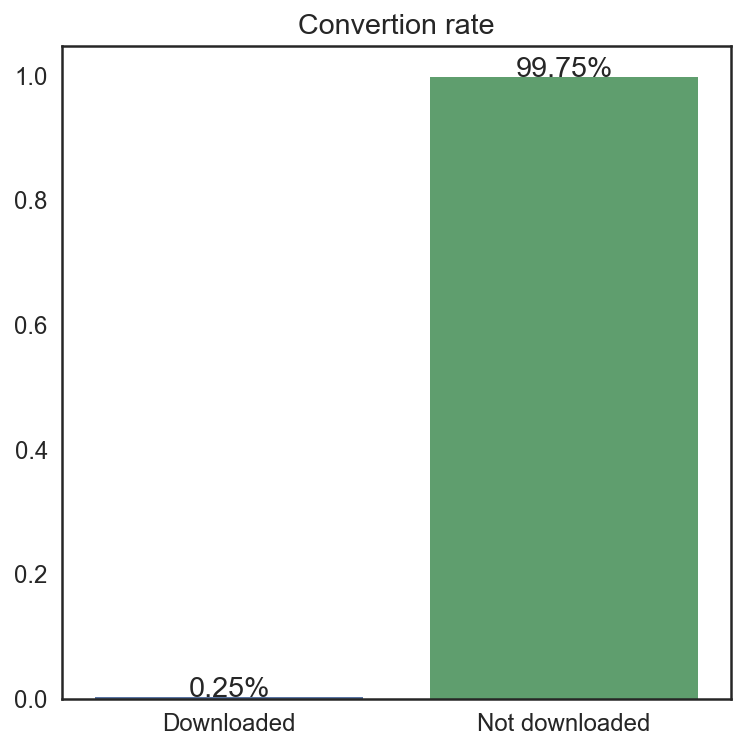

In [46]:
plt.figure(figsize=(6,6))
downl = (train.is_attributed.values == 1).mean()
ndownl = 1 - downl
downloads = [downl, ndownl]
cols = ['Downloaded', 'Not downloaded']

ax = sns.barplot(cols, downloads)
ax.set(title='Convertion rate')

for c, d in zip(ax.patches, downloads):
    height=c.get_height()
    ax.text(c.get_x()+c.get_width()/2.,
            height,
            '{}%'.format(round(d*100,2)),
            ha="center")  

Oberservamos que a taxa de conversão é muito baixa. Apenas 0,25% dos cliques se convertem em verdadeiros downloads! Isso já nos dá alguma evidência que muitos cliques falsos de fato ocorrem. Será que os IPs podem nos ajudar a identificar a fonte desses cliques falsos?

Vamos tentar explorar um pouco mais a identificação dos cliques por IP para responder coisas como:

   * Um IP que clica muitas vezes também baixa muitas vezes?
   * Quão concetrado está o número de cliques em cada IP?

In [47]:
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,5348,123470
1,5314,117347
2,73516,77004
3,73487,76840
4,53454,49921
5,114276,42474
6,26995,40440
7,95766,37828
8,17149,31147
9,105475,30513


In [48]:
train= train.merge(temp, on='ip', how='left')

In [49]:
# Pegando no Dataframe train somente os clicks que fizeram download
train_dwl=train[train['is_attributed']==1].sort_values('counts', ascending=False)
train_dwl[:10]

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds,counts
10231546,5348,3,2,22,280,1,8,10,20,30,123470
11420008,5348,19,395,21,213,1,8,13,45,25,123470
15110489,5348,19,0,24,268,1,9,5,38,10,123470
5000746,5348,121,1,19,203,1,7,12,50,16,123470
15111255,5348,19,231,24,213,1,9,5,38,18,123470
18238178,5348,9,1,19,127,1,9,15,8,59,123470
4938752,5348,107,1,13,171,1,7,12,37,47,123470
15116229,5348,45,1,19,411,1,9,5,39,9,123470
2866306,5348,19,0,29,347,1,7,5,45,26,123470
5597992,5348,9,1,19,232,1,7,14,42,13,123470


Text(0.5,1,'Counts vs Tx de conversão')

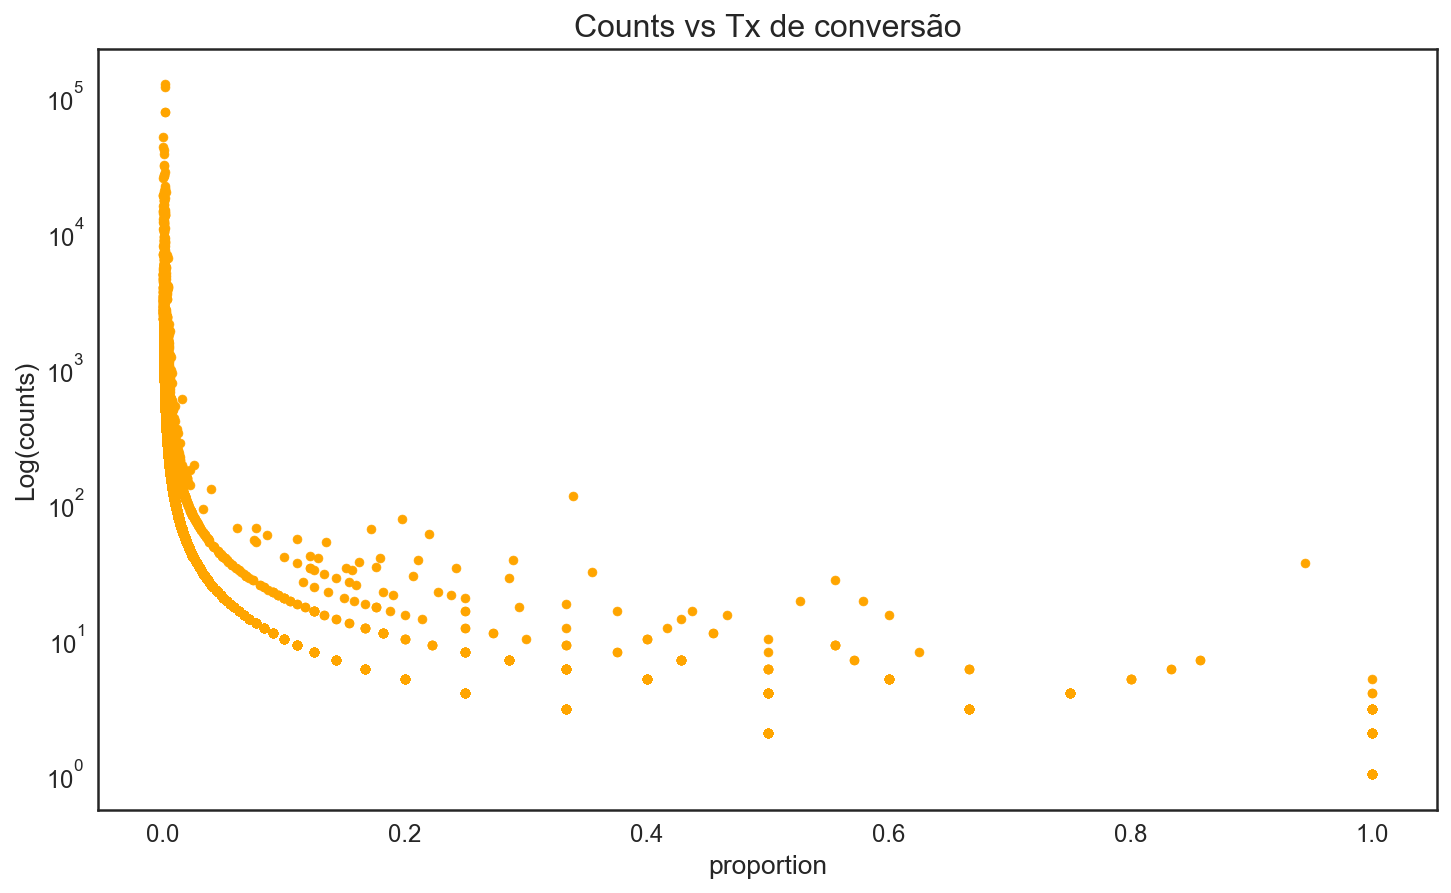

In [50]:

clicks = train_dwl[['ip','counts']].groupby('ip', as_index=False).mean().sort_values('counts', ascending=False)
downl = train_dwl[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)

clicks = clicks.merge(downl, on='ip', how='left')
clicks['proportion'] = clicks['is_attributed']/clicks['counts']
clicks.drop(columns=['is_attributed'])

g1 = clicks.plot(kind='scatter', x='proportion', y='counts', color='orange', figsize=(12,7), logy=True)
g1.set_ylabel('Log(counts)')
g1.set_title('Counts vs Tx de conversão', fontsize=16)

Vemos no gráfico acima que IPs que fazem muitos cliques de fato se convertem em downloads em uma taxa muito menor do que IPs que fazem poucous cliques. Acreditamos que essa relação possa ser utilizada na fase de construção do modelo preditivo.

Vamos tentar agora analisar a concentração dos IPs. Como o número de IPs diferentes é muito grande, vamos criar 4 clusters de IPs, cada cluster representando um quartil da amostra de cliques

In [51]:
# Colocando no dtFrame de teste a coluna de contagem de clicks também
temp = test['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
test = test.merge(temp, on='ip', how='left')

# Usando a contagem de clicks para classificar as linhas dos dtFrames
categories = ['low click', 'med click', 'high click']

test['click_class'] = pd.qcut(test['counts'], 3, categories)
train['click_class'] = pd.qcut(train['counts'], 3, categories)


In [52]:
test.head()

,ip,app,device,os,channel,days,hours,minutes,seconds,counts,click_class
0,5744,9,1,3,107,10,4,0,0,91,low click
1,119901,9,1,3,466,10,4,0,0,2083,high click
2,72287,21,1,19,128,10,4,0,0,2135,high click
3,78477,15,1,13,111,10,4,0,0,1201,med click
4,123080,12,1,13,328,10,4,0,0,208,low click


In [53]:
train.head()

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds,counts,click_class
0,103022,3,1,23,379,0,6,14,37,44,571,med click
1,114221,3,1,19,379,0,6,14,37,59,175,low click
2,47902,3,1,17,379,0,6,14,48,7,551,med click
3,23550,3,1,13,379,0,6,14,53,39,328,low click
4,84644,3,1,19,379,0,6,14,56,49,6326,high click


In [75]:
len(temp['ip'].unique())

163354

In [92]:
classes = ['low click', 'med click', 'high click']
dataframes = [train, test]
cols = ['ip', 'app', 'device', 'os', 'channel']


resume_test = {}
for df in dataframes:
    resume = {}
    for cl in classes:
        x = {}
        for col in cols:
            temp = df[df['click_class']==cl]
            x['{}'.format(col)] = len(temp[col].unique())
        
        resume['{}'.format(cl)] = x
    resume_train = {}
    

AttributeError: 'DataFrame' object has no attribute 'name'

In [91]:
print(resume_tot)

{'              ip  app  device  os  channel  is_attributed  days  hours  \\\n0         103022    3       1  23      379              0     6     14   \n1         114221    3       1  19      379              0     6     14   \n2          47902    3       1  17      379              0     6     14   \n3          23550    3       1  13      379              0     6     14   \n4          84644    3       1  19      379              0     6     14   \n5         147605    3       1  19      379              0     6     15   \n6         197717    3       1  19      379              0     6     15   \n7         127226    3       1  13      379              0     6     15   \n8          78119   64       1  14      459              0     6     15   \n9         139298    3       1  13      379              0     6     15   \n10        106524    3       1  13      379              0     6     15   \n11        182818    3       1  19      379              0     6     15   \n12         88100    3 

[Text(0.5,1,'Número de IPs em cada cluster de clique - Teste')]

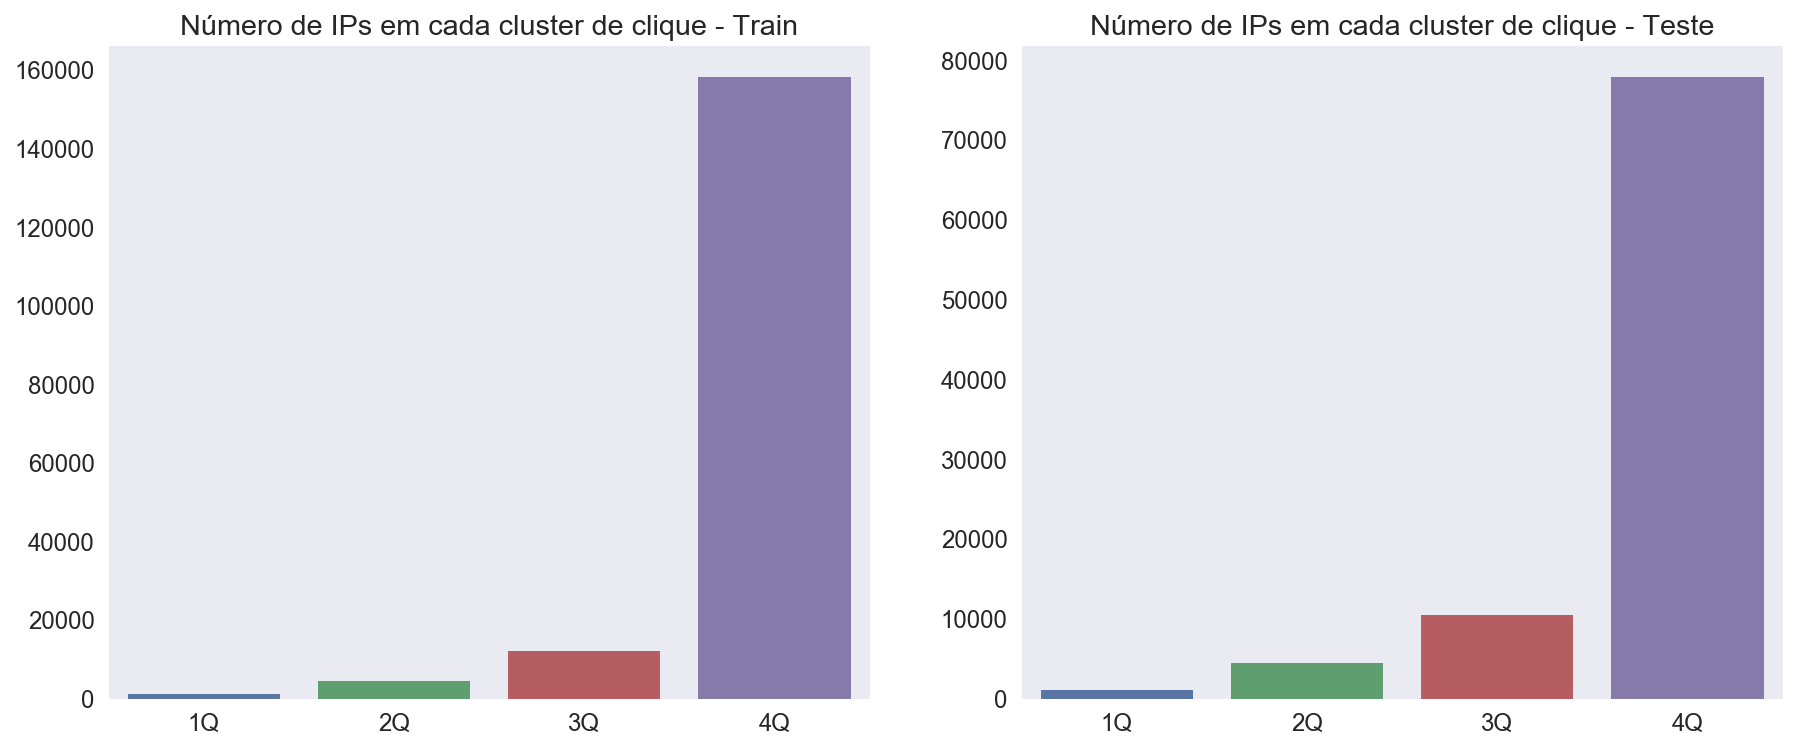

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
y_train = [len(quartil1_train['ip']), len(quartil2_train['ip']), len(quartil3_train['ip']), len(quartil4_train['ip'])]
y_test = [len(quartil1_test['ip']), len(quartil2_test['ip']), len(quartil3_test['ip']), len(quartil4_test['ip'])]

g1 = sns.barplot(['1Q', '2Q', '3Q', '4Q'], y_train, ax=axs[0])
g1.set(title='Número de IPs em cada cluster de clique - Train')

g2 = sns.barplot(['1Q', '2Q', '3Q', '4Q'], y_test, ax=axs[1])
g2.set(title='Número de IPs em cada cluster de clique - Teste')


Constatamos que além dos IPs associados a muitos cliques terem uma baixa taxa de conversão, na região com muitos cliques os IPs são muito mais concentrados. Acreditamos que isso seja mais evidência que esses IPs estejam ligados a cliques falsos e que a informação de quais IPs estão no 1Q da distribuição pode ajudar o modelo preditivo. Importante também destacar que esse padrão se conserva nos dados de teste.


In [ ]:
#Talvez fosse legal fazer aquele grafico com as varias correl entre as varias para observar se há algum padrão 
#entre counts e outras variáveis